# Zuber Platform
Zuber, a new ride-sharing company launching in Chicago. The task is to identify patterns within the available data. You aim to understand passenger preferences and the impact of external factors on ride behavior. <br>
While working with a database, we'll analyze data from competitors and test a hypothesis about the effect of weather conditions on trip frequency.

## Data Dictionary
A database containing information about taxi trips in Chicago:

DataSet Companies (project_sql_results_01):
-	company_name: data on the names of taxi companies
-	trips_amount: the number of trips completed by each taxi company on November 15 and 16, 2017

DataSet Trips (project_sql_results_04):
-	dropoff_location_name: Chicago neighborhoods where trips ended
-	average_trips: data on the average number of trips that ended in each neighborhood in November 2017

DataSet loop_ohare (project_sql_results_07):
-	start_ts: pickup date and time (hrs)
-	weather_conditions: weather conditions at the time the trip began
-	duration_seconds: duration of the trip in seconds

# 1. Initialization

In [1]:
# Import functions
import sys
import os

sys.path.append(os.path.abspath('..'))

In [2]:
# Load libraries
import pandas as pd
import numpy as np
from scipy import stats
from math import factorial
import seaborn as sns
from matplotlib import pyplot as plt

from src.null_columns import show_null_columns

In [ ]:
# Extract the info from the Datasets

df_companies = pd.read_csv('../data/raw/project_sql_result_01.csv')
df_trips = pd.read_csv('../data/raw/project_sql_result_04.csv')
df_loop_ohare = pd.read_csv('../data/raw/project_sql_result_07.csv')

# 2. Data Preprocessing
### 2.1 Copy original Dataframes

In [4]:
df_companies_clean = df_companies.copy()
df_trips_clean = df_trips.copy()
df_loop_ohare_clean = df_loop_ohare.copy()

### 2.2 duplicate values / null values
#### 2.2.1 Dataframe Companies

In [5]:
# General View
df_companies.info()
print()
print(df_companies.sample(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB

                        company_name  trips_amount
31  American United Taxi Affiliation           210
26                   Gold Coast Taxi           428
54         2192 - 73487 Zeymane Corp            14


Duplicate Values

In [6]:
print(f"The duplicate rows are: {df_companies_clean.duplicated().sum()}")  # Sum of Duplicated rows
"""
To make sure the company names are well captured in the database, a new column with the data in column 'company_name' will be created, 
to convert the data to lowercase, then check duplicate values.
"""
df_companies_clean['new_col'] = df_companies_clean['company_name'].str.lower()
print("The number of unique companies is:", df_companies_clean['new_col'].nunique())
print('The number of duplicated values in "new_col" is: ', df_companies_clean['new_col'].duplicated().sum())  # Duplicates in 'new_col'

The duplicate rows are: 0
The number of unique companies is: 64
The number of duplicated values in "new_col" is:  0


In [7]:
# Remove new_col. No needed for further analysis
del df_companies_clean['new_col']

Null Values

In [9]:
show_null_columns(df_companies_clean)


Columns with null values in Dataset:
No null values found


#### 2.2.2 Dataframe Trips

In [10]:
# General View
df_trips.info()
print()
print(df_trips.sample(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB

   dropoff_location_name  average_trips
43         Mckinley Park      64.033333
57               Hermosa      27.566667
32               Douglas     142.900000


Duplicated Values

In [11]:
print(f"The duplicate rows are: {df_trips_clean.duplicated().sum()}")  # Sum of Duplicated rows
"""
To make sure the dropoff location names are well captured in the database, a new column with the data in column 'dropoff_location_name ' will be created, 
to convert the data to lowercase, then check duplicate values.
"""
df_trips_clean['new_col'] = df_trips_clean['dropoff_location_name'].str.lower()
print("The number of unique drop-off locations is:", df_trips_clean['new_col'].nunique())
print('The number of duplicated values in "new_col" is: ', df_trips_clean['new_col'].duplicated().sum())  # Duplicates in 'new_col'

The duplicate rows are: 0
The number of unique drop-off locations is: 94
The number of duplicated values in "new_col" is:  0


In [12]:
# Remove new_col. No needed for further analysis
del df_trips_clean['new_col']

Null Values

In [13]:
show_null_columns(df_trips_clean)


Columns with null values in Dataset:
No null values found


#### 2.2.3 Dataframe loop_ohare

In [15]:
# General View
df_loop_ohare.info()
print()
print(df_loop_ohare.sample(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB

                 start_ts weather_conditions  duration_seconds
880   2017-11-11 10:00:00               Good            1320.0
1048  2017-11-11 17:00:00               Good            2280.0
668   2017-11-04 15:00:00               Good            3300.0


In [16]:
# Reviewing DataTypes
"""
Findings:
About this dataset, datatypes must be changed. Column 'duration_seconds' are printed as int, but showing as float.
Column 'start_ts' is showing as object, and this column represents the date and hr of starting the trip, should be changed to datetime.
"""
# Data integrity
df_loop_ohare_clean['duration_seconds'] = df_loop_ohare_clean['duration_seconds'].astype(int)
df_loop_ohare_clean['start_ts'] = pd.to_datetime(df_loop_ohare_clean['start_ts'])
print(df_loop_ohare_clean.dtypes)

start_ts              datetime64[ns]
weather_conditions            object
duration_seconds               int64
dtype: object


Duplicated Values

In [17]:
"""
Findings:
This dataset has 197 duplicate rows out of 1068, representing 18.45% of the data. 
Due to the nature of the dataset, the odds are quite high, but considering pickup time in hrs, the rows must be kept for now.
"""
print(f"The duplicate rows are: {df_loop_ohare_clean.duplicated().sum()}")  # Sum of Duplicated rows
print(f"The percent of duplicate rows is: {(df_loop_ohare_clean.duplicated().mean() *100).round(2)}%")
print()
print(df_loop_ohare_clean[df_loop_ohare_clean.duplicated()])

The duplicate rows are: 197
The percent of duplicate rows is: 18.45%

                start_ts weather_conditions  duration_seconds
62   2017-11-11 06:00:00               Good              1260
74   2017-11-11 08:00:00               Good              1380
76   2017-11-04 09:00:00               Good              1380
117  2017-11-11 07:00:00               Good              1380
119  2017-11-04 14:00:00               Good              3300
...                  ...                ...               ...
1054 2017-11-11 07:00:00               Good              1380
1058 2017-11-25 12:00:00               Good              1440
1062 2017-11-11 06:00:00               Good              1500
1065 2017-11-11 13:00:00               Good              2100
1066 2017-11-11 08:00:00               Good              1380

[197 rows x 3 columns]


Null Values

In [18]:
show_null_columns(df_loop_ohare_clean)


Columns with null values in Dataset:
No null values found


Findings: <br>
For the df_companies and df_trips DataFrames, no data inconsistencies were found, so we can proceed with the analysis. <br>
In the case of the df_loop_ohare DataFrame, the data type was changed from float to int to optimize subsequent analysis, and all values in the start_ts column were ensured to be in datetime format.

# 3. Data Analysis
### 3.1 Top Neighborhoods by Trip Dropoff

dropoff_location_name
Loop                  10727.466667
River North            9523.666667
Streeterville          6664.666667
West Loop              5163.666667
O'Hare                 2546.900000
Lake View              2420.966667
Grant Park             2068.533333
Museum Campus          1510.000000
Gold Coast             1364.233333
Sheffield & DePaul     1259.766667
Name: average_trips, dtype: float64


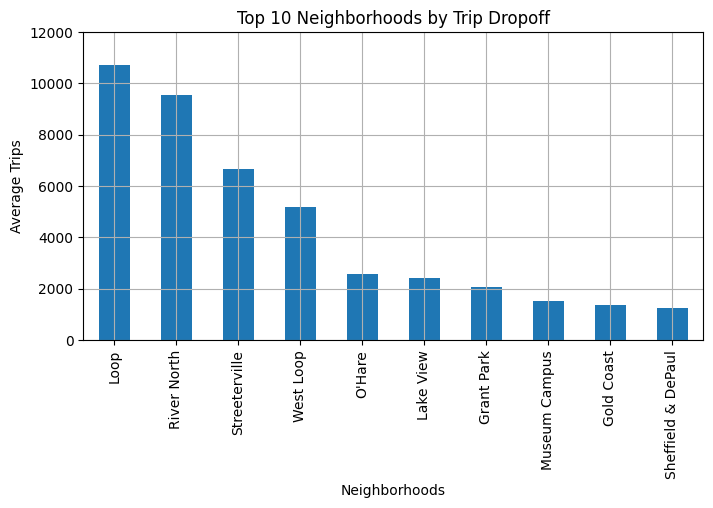

In [20]:
# Identify the top 10 neighborhoods by trip dropoff
top_neighborhoods = df_trips_clean.groupby(by='dropoff_location_name')['average_trips'].sum()
top_neighborhoods = top_neighborhoods.sort_values(ascending=False)
print(top_neighborhoods.head(10))

# Visualizing the results
ax = top_neighborhoods.head(10).plot(
    title='Top 10 Neighborhoods by Trip Dropoff',
    kind="bar",
    figsize=(8,4),
    grid=True,
    ylim=(0,12000),
    xlabel="Neighborhoods",
    ylabel="Average Trips"
)
plt.show()

### 3.2 Top cab companies by Trip numbers

company_name
Flash Cab                            19558
Taxi Affiliation Services            11422
Medallion Leasin                     10367
Yellow Cab                            9888
Taxi Affiliation Service Yellow       9299
Chicago Carriage Cab Corp             9181
City Service                          8448
Sun Taxi                              7701
Star North Management LLC             7455
Blue Ribbon Taxi Association Inc.     5953
Name: trips_amount, dtype: int64


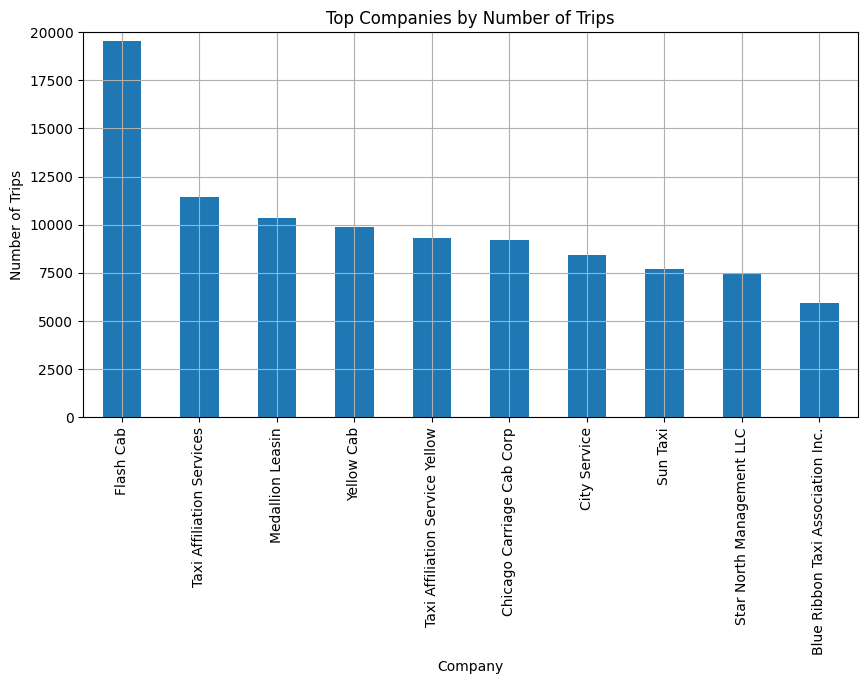

In [21]:
# Taxi companies and trip counts
# Identify taxi companies by their number of trips.
top_companies_trips = df_companies_clean.groupby(by='company_name')['trips_amount'].sum()
top_companies_trips = top_companies_trips.sort_values(ascending=False)
print(top_companies_trips.head(10))

# Visualizing the results
ax = top_companies_trips.head(10).plot(
    title='Top Companies by Number of Trips',
    kind="bar",
    figsize=(10,5),
    grid=True,
    ylim=(0,20000),
    xlabel="Company",
    ylabel="Number of Trips"
)
plt.show()

Findings: <br>
Based on the analysis of the graphs, the following observations can be made: <br>
The main destinations where trips tend to end are:
-	Loop
-	River North
-	Streeterville
-	West Loop

These appear to be the preferred dropoff locations for users. These four neighborhoods exceed 5,000 average trips, while the remaining six fall between 1,250 and 2,500. The Loop stands out as the top destination, with an average of nearly 11,000 trips. <br>
<br>
About the top taxi companies by number of trips, Flash Cab is clearly the most preferred company, showing a strong lead over all competitors. It records 19,558 trips, compared to Taxi Affiliation Services, which ranks second with 11,422 trips.

# 4. Hypothesis Testing
Hypotheses <br>

- H₀ (Null Hypothesis): There is no difference in the average trip duration from the Loop to O'Hare International Airport on rainy Saturdays versus non-rainy Saturdays.

- H₁ (Alternative Hypothesis): There is a difference in the average trip duration from the Loop to O'Hare International Airport on rainy Saturdays versus non-rainy Saturdays.

In [22]:
# Significance Level
alpha = 0.05

# Filter trips occurring on Saturdays
df_saturday = df_loop_ohare_clean[df_loop_ohare_clean['start_ts'].dt.weekday == 5]

# Separate rainy and non-rainy Saturdays
saturday_rain = df_saturday[df_saturday['weather_conditions'] == 'Bad']['duration_seconds']
saturday_no_rain = df_saturday[df_saturday['weather_conditions'] == 'Good']['duration_seconds']

# Resolucion de Hipotesis
# Check equality of variances thru Levene's test
statistics, p_value = stats.levene(saturday_rain, saturday_no_rain)
print(f'Valor para la prueba de Levene es: {p_value: .5f}')
if (p_value < alpha):
    print("Reject the null hypothesis: variances are different.")
else:
    print("Fail to reject the null hypothesis: variances are not different.")

# Since Levene’s test shows no significant difference in variances, we use a two-sample t-test:
t_stat, p_value = stats.ttest_ind(saturday_rain, saturday_no_rain, equal_var=False)
print(f'T-statistic: {t_stat: .10f}')
print(f'p-value: {p_value: .18f}')
print()

if p_value < alpha:
    print("Reject the null hypothesis: there is a difference in average trip duration.")
else:
    print("Fail to reject the null hypothesis: no evidence of a difference.")

Valor para la prueba de Levene es:  0.53320
Fail to reject the null hypothesis: variances are not different.
T-statistic:  7.1860342881
p-value:  0.000000000006738994

Reject the null hypothesis: there is a difference in average trip duration.


# 5. Conclusion
To conclude with this analysis, I'll point out by sections: 

1. Passenger Preferences and Key Locations
The analysis of dropoff locations reveals highly concentrated demand in specific neighborhoods.
- Primary Hubs: The Loop is the undisputed center of activity, recording an average of approximately 10,727 trips in November 2017. It is  followed closely by River North (9,523 trips), Streeterville (6,664 trips), and West Loop (5,163 trips).
- Strategic Focus: These four neighborhoods represent the highest density of ride terminations. For a new company like Zuber, marketing efforts and driver allocation should be heavily concentrated in these downtown areas to capture the highest volume of potential passengers.

2. Competitive Landscape
The market is currently dominated by a few major players, with one standing out significantly.
- Market Leader: Flash Cab is the clear market leader with 19,558 trips recorded over the two-day sample period.
- Competition Gap: Flash Cab performed nearly double the volume of its closest competitor, Taxi Affiliation Services (11,422 trips). Zuber enters a market with strong incumbents, suggesting a need for competitive pricing or unique value propositions to gain market share.

3. Impact of Weather on Operations
- A critical part of ride-sharing logistics is estimating travel times accurately. We tested the hypothesis that rainy weather alters trip duration from the Loop to O'Hare International Airport on Saturdays.

- Statistical Evidence: Using a t-test, we obtained a p-value <0.05.
- Result: We rejected the null hypothesis. There is a statistically significant difference in trip duration between rainy and non-rainy Saturdays. This being said, the rain significantly impacts traffic conditions. Zuber's algorithms for the estimated time of arrival, and pricing (surge pricing) must account for weather conditions to maintain customer satisfaction and driver efficiency.

So, to consider:
- Geographic Targeting: Prioritize driver availability in the Loop, River North, and Streeterville, as these areas generate the vast majority of dropoffs.
- Weather Algorithms: Implement dynamic estimated time of arrival adjustments during rainy weather, particularly for long-distance trips like the Loop to O'Hare route, as the data proves weather significantly affects duration.
- Competitor Analysis: Study Flash Cab's operational model to understand why they hold such a commanding lead over other taxi services